In [24]:
using Gen
using PyPlot
using Distributions

In [121]:
function desired_next_step(u::String, x::Float64, y::Float64)
    if u == "U"
        y += 1.
    elseif u == "D"
        y += -1.
    elseif u == "R"
        x += 1.
    elseif u == "L"
        x += -1.
    end
    return x,y
end

desired_next_step (generic function with 1 method)

### Generative Controlled Robot Program

In this program a robot is given commands (or directions) to move to. It moves up (U), down (D), left (L), or right (R) at each step. There is a chance that the robot will "Break", and remain broken. While the robot is broken, it moves to a random direction at each step.

In [125]:

#each index matches whether it was broken or not on that location. For instance the first position is always not
function controlled_robot_program(T::Trace, user_controls::Array{String,1})
    possible_controls = ["R","U","L","D"]
    
    curr_x = 0.
    curr_y = 0.
    
    dxs = []
    dys = []
    b = []
    
    for i=1:length(user_controls)
        
        #Determine if the robot breaks or not
        #..or if already broken, stay broken
        if i != 1 && b[i-1]
            push!(b, flip(1) ~ "b$i") 
        else
            push!(b, flip(0.2) ~ "b$i")
        end
        
        #Given broken, determine the 'control'
        if b[i]
            #randomly sample new control
            u = possible_controls[rand(1:4)]
        else
            u = user_controls[i] # R, U, L , or D
        end
        
        #Given the 'control', gives the position of what the next desired step is 
        desired_x, desired_y = desired_next_step(u, curr_x, curr_y)
        
        #Just for likelihood check later
        push!(dxs, desired_x)
        push!(dys, desired_y)
        
        #Add some noise to the desired next step
        curr_x = normal(desired_x, 0.075) ~ "x$i"
        curr_y = normal(desired_y, 0.075) ~ "y$i"
        
    end
    # needed to manually check the likelihood of the program
    return dxs, dys
end
    

controlled_robot_program (generic function with 1 method)

### Contrain X and Y and Manually Compute Likelihood

In [126]:
#---------------------------------
#Run Program and show log_weight
#---------------------------------

u = ["R","U","L","D"]
robot_trace = Trace()

xs = [0.97,0.87,-0.20,-0.16]
ys = [-0.10, 0.93, 0.92, -0.17]

for i=1:length(u)
    robot_trace["x$i"] = xs[i]
    robot_trace["y$i"] = ys[i]
end 

dxs, dys = controlled_robot_program(robot_trace, u)
println("robot_trace.log_weight: $(robot_trace.log_weight)")

#---------------------------------
#Compute the likelihood manually
#---------------------------------

P=0
for i=1:4
    P += logpdf(Normal(dxs[i], 0.075), xs[i])
    P += logpdf(Normal(dys[i], 0.075), ys[i])
end
    
println("manual likelihood: $P") 

robot_trace.log_weight: 10.126184613484785
manual likelihood: 10.126184613484785


### Show the path of the robot. 

#### Red means the direction was chosen while broken (randomly)

#### **NOTE:** When the robot is broken, it chooses a random direction from the set of all directions. This means that there is a 25% chance that the robot will choose the correct direction while broken

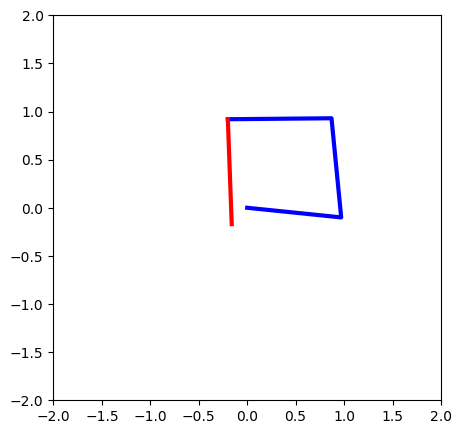

(-2,2)

In [41]:
plt[:figure](figsize=(5, 5))

zero_start_xs = [0.]
zero_start_ys = [0.]

zero_start_xs = vcat(zero_start_xs, map((i) -> robot_trace["x$i"], 1:length(u)))
zero_start_ys = vcat(zero_start_ys, map((i) -> robot_trace["y$i"], 1:length(u)))

bs = map((i) -> robot_trace["b$i"], 1:length(u))
broken_index = findfirst(bs, true)
if broken_index != 0
    plt[:plot](zero_start_xs[1:broken_index], zero_start_ys[1:broken_index], color="blue", lw=3)
    plt[:plot](zero_start_xs[broken_index:end], zero_start_ys[broken_index:end], color="red", lw=3)
else
    plt[:plot](zero_start_xs, zero_start_ys, color="blue", lw=3)
end

plt[:xlim](-2,2)
plt[:ylim](-2,2)



In [7]:
function render_observed_path_trace(trace::Trace,
                                         xs::Array{Float64,1}, ys::Array{Float64,1},
                                         ax, xlim, ylim)
    
    zero_start_xs = [0.]
    zero_start_ys = [0.]

    zero_start_xs = vcat(zero_start_xs, xs)
    zero_start_ys = vcat(zero_start_ys, ys)

    bs = map((i) -> trace["b$i"], 1:length(xs))
    broken_index = findfirst(bs, true)
    if broken_index != 0
        ax[:plot](zero_start_xs[1:broken_index], zero_start_ys[1:broken_index], color="blue", lw=3)
        ax[:plot](zero_start_xs[broken_index:end], zero_start_ys[broken_index:end], color="red", lw=3)
    else
        ax[:plot](zero_start_xs, zero_start_ys, color="blue", lw=3)
    end

    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
    
end

render_observed_path_trace (generic function with 1 method)

### Run `controlled_robot_program` 36 times (Prior)
## Without Contraints


In [111]:
traces = []
u = ["R","U","L","D"]
log_weights = []
for replicate=1:36
    trace = Trace()
    controlled_robot_program(trace, u)
    push!(traces, trace)
    push!(log_weights, trace.log_weight)
end

### Plot all Priors

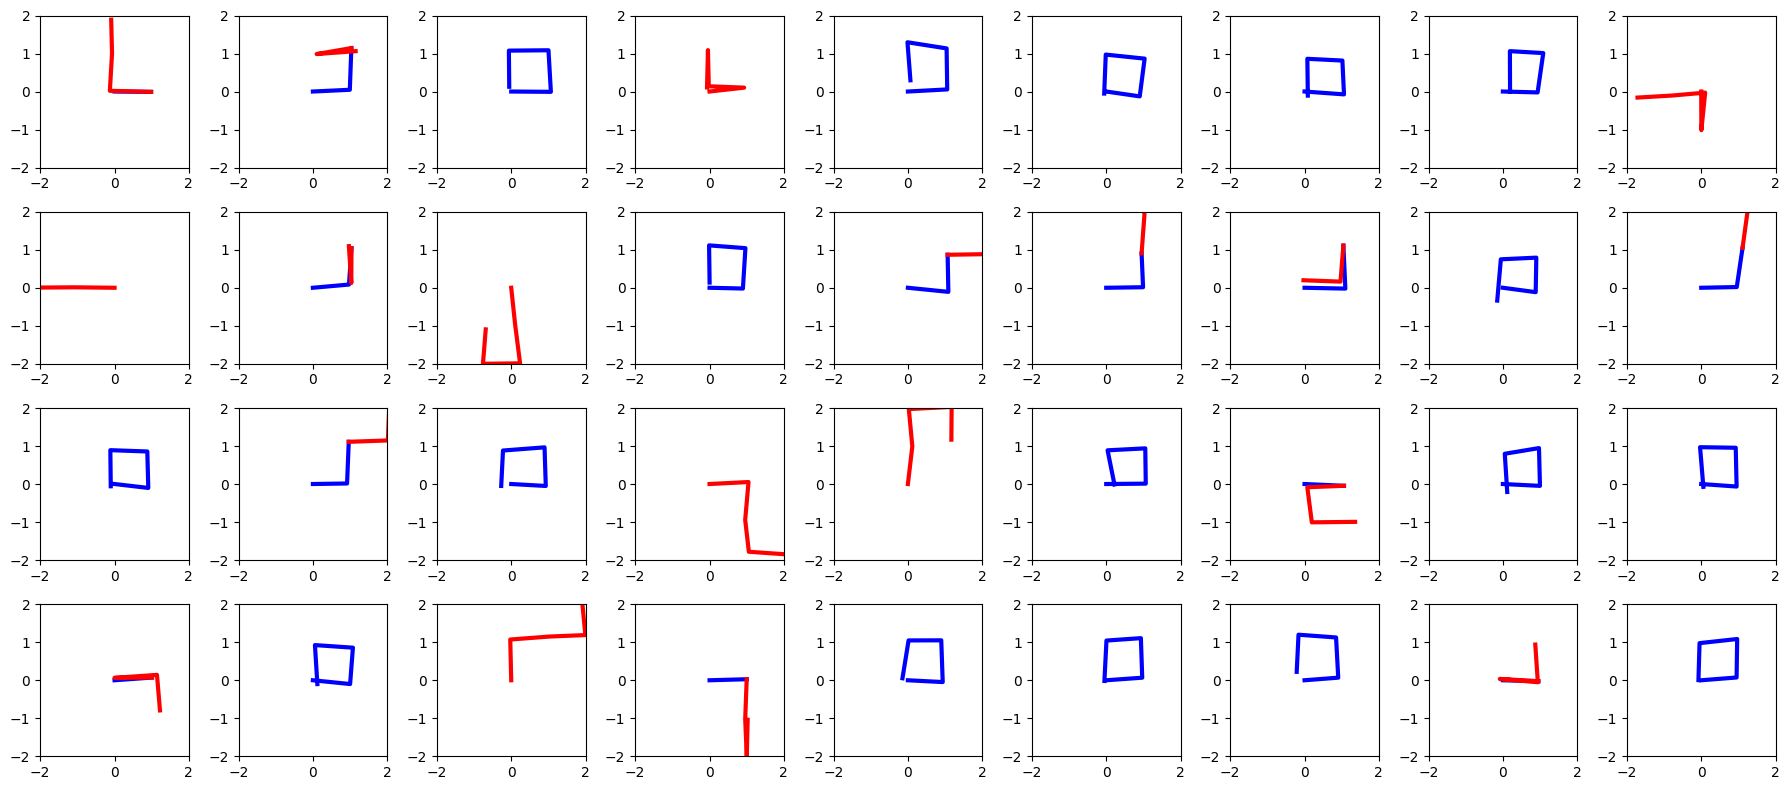

In [113]:
plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-2., 2.]
    ylim = [-2., 2.]
    obs_xs =  map((i) -> trace["x$i"], 1:length(u))
    obs_ys =  map((i) -> trace["y$i"], 1:length(u))
    render_observed_path_trace(trace, obs_xs, obs_ys, ax, xlim, ylim)
end
plt[:tight_layout]()

### Run `controlled_robot_program` 36 times (Posterior)
### Contraining X and Y and viewing likelihoods

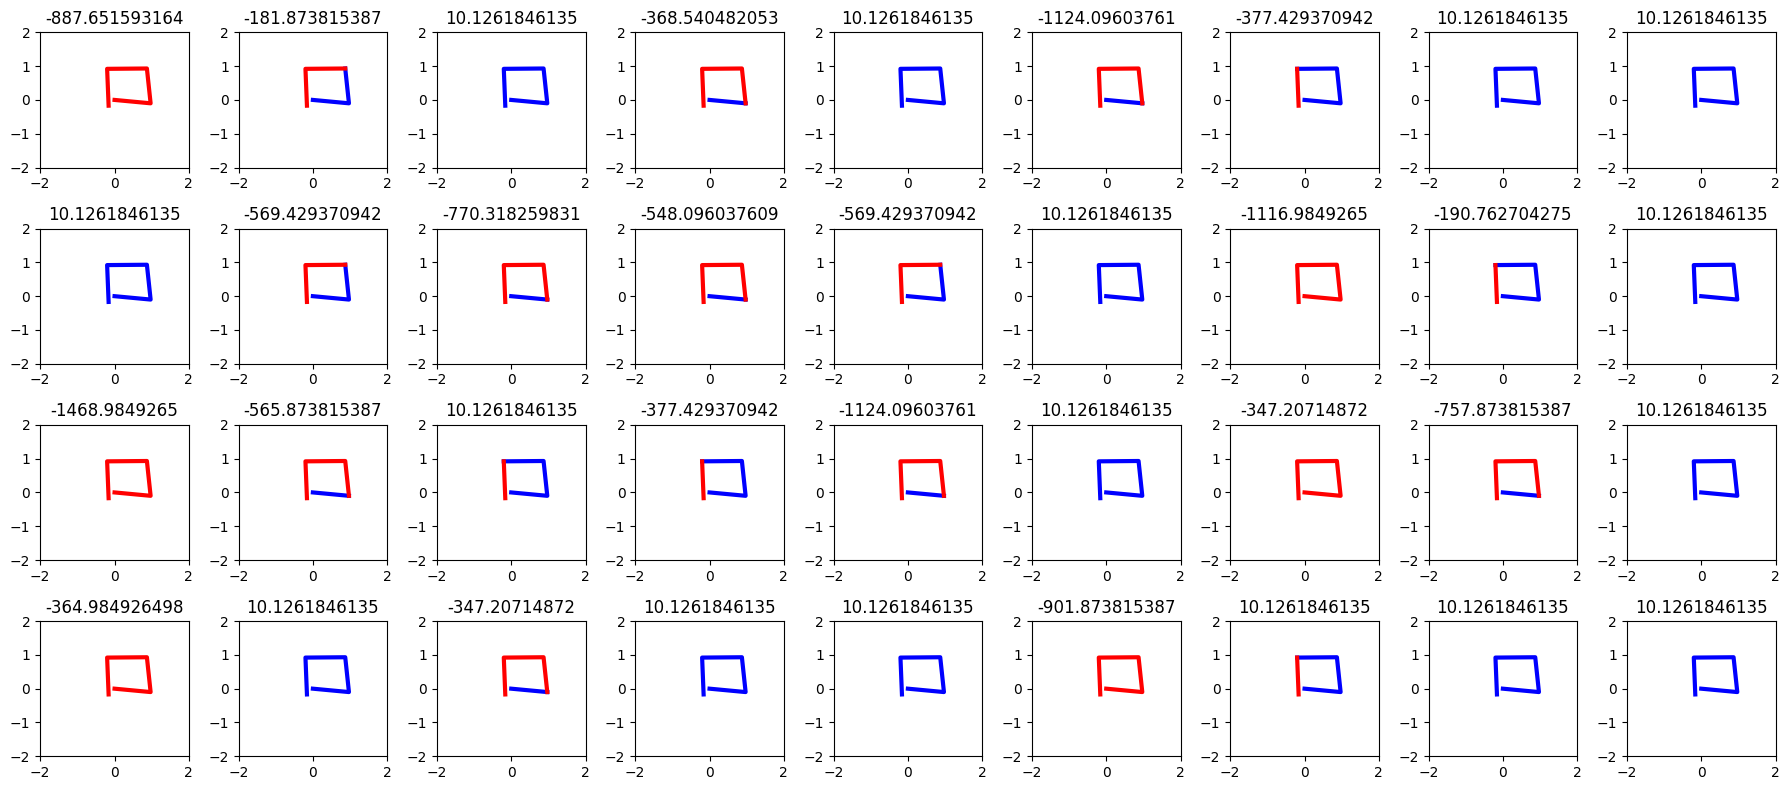

In [47]:
traces = []
u = ["R","U","L","D"]
log_weights = []
xs = [0.97,0.87,-0.20, -0.16]
ys = [-0.10, 0.93, 0.92, -0.17]
for replicate=1:36
    trace = Trace()
    
    for i=1:length(u)
        trace["x$i"] = xs[i]
        trace["y$i"] = ys[i]
    end 
    
    controlled_robot_program(trace, u)
    push!(traces, trace)
    push!(log_weights, trace.log_weight)
end

#----------------------------------
# PLOT
#----------------------------------

plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-2., 2.]
    ylim = [-2., 2.]
    ax[:title][:set_text](log_weights[i])
    render_observed_path_trace(trace, xs, ys, ax, xlim, ylim)
end
plt[:tight_layout]()

In [49]:
function logsumexp(x::Array{Float64,1})
    maxx = maximum(x)
    maxx + log(sum(exp(x - maxx)))
end

function robot_control_likelihood_weighting(num_samples::Int, xs::Array{Float64,1}, 
                                               ys::Array{Float64,1})
    log_weights = Array{Float64,1}(num_samples)
    traces = Array{Trace,1}(num_samples)
    for sample=1:num_samples
        trace = Trace()
        
        
        for i=1:length(u)
        trace["x$i"] = xs[i]
        trace["y$i"] = ys[i]
        end 

        controlled_robot_program(trace, u)
        
        
        traces[sample] = trace
        log_weights[sample] = trace.log_weight
    end
    weights = exp(log_weights - logsumexp(log_weights))
    chosen = rand(Distributions.Categorical(weights))
    return traces[chosen]
end



robot_control_likelihood_weighting (generic function with 1 method)

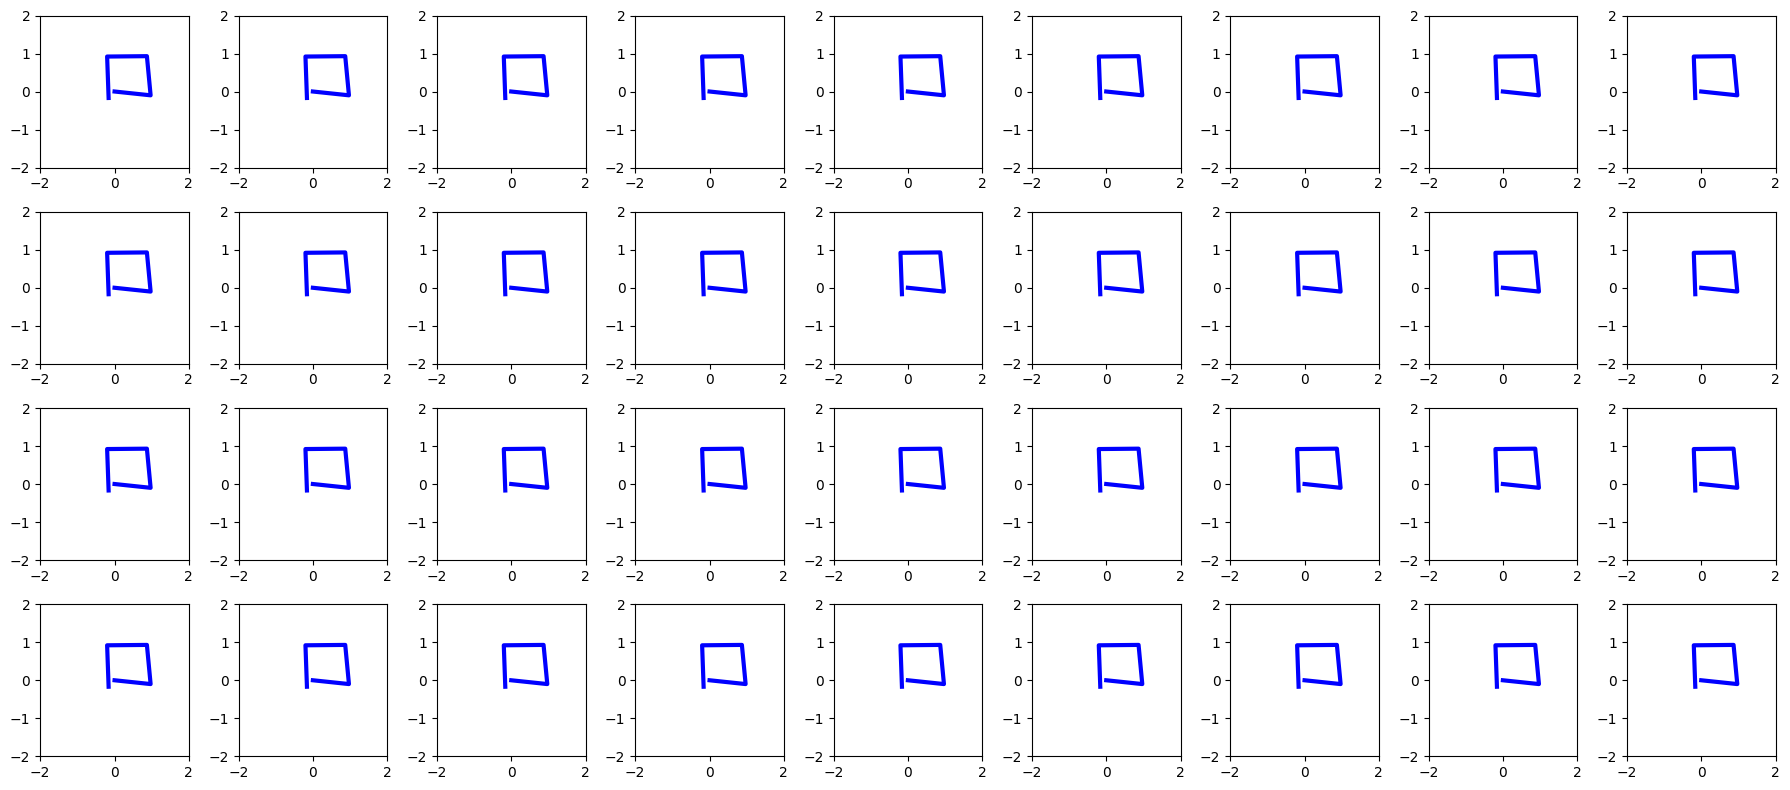

In [50]:
u = ["R","U","L","D"]
xs = [0.97,0.87,-0.20, -0.16]
ys = [-0.10, 0.93, 0.92, -0.17]

traces = []
num_samples = 10000
for replicate=1:36
    trace = Trace()
    push!(traces, robot_control_likelihood_weighting(num_samples, xs, ys))
end

plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-2., 2.]
    ylim = [-2., 2.]
    render_observed_path_trace(trace, xs, ys, ax, xlim, ylim)
end

plt[:tight_layout]()

## New Data 

### Let's try more user controls into the robot

#### What do the priors look like?

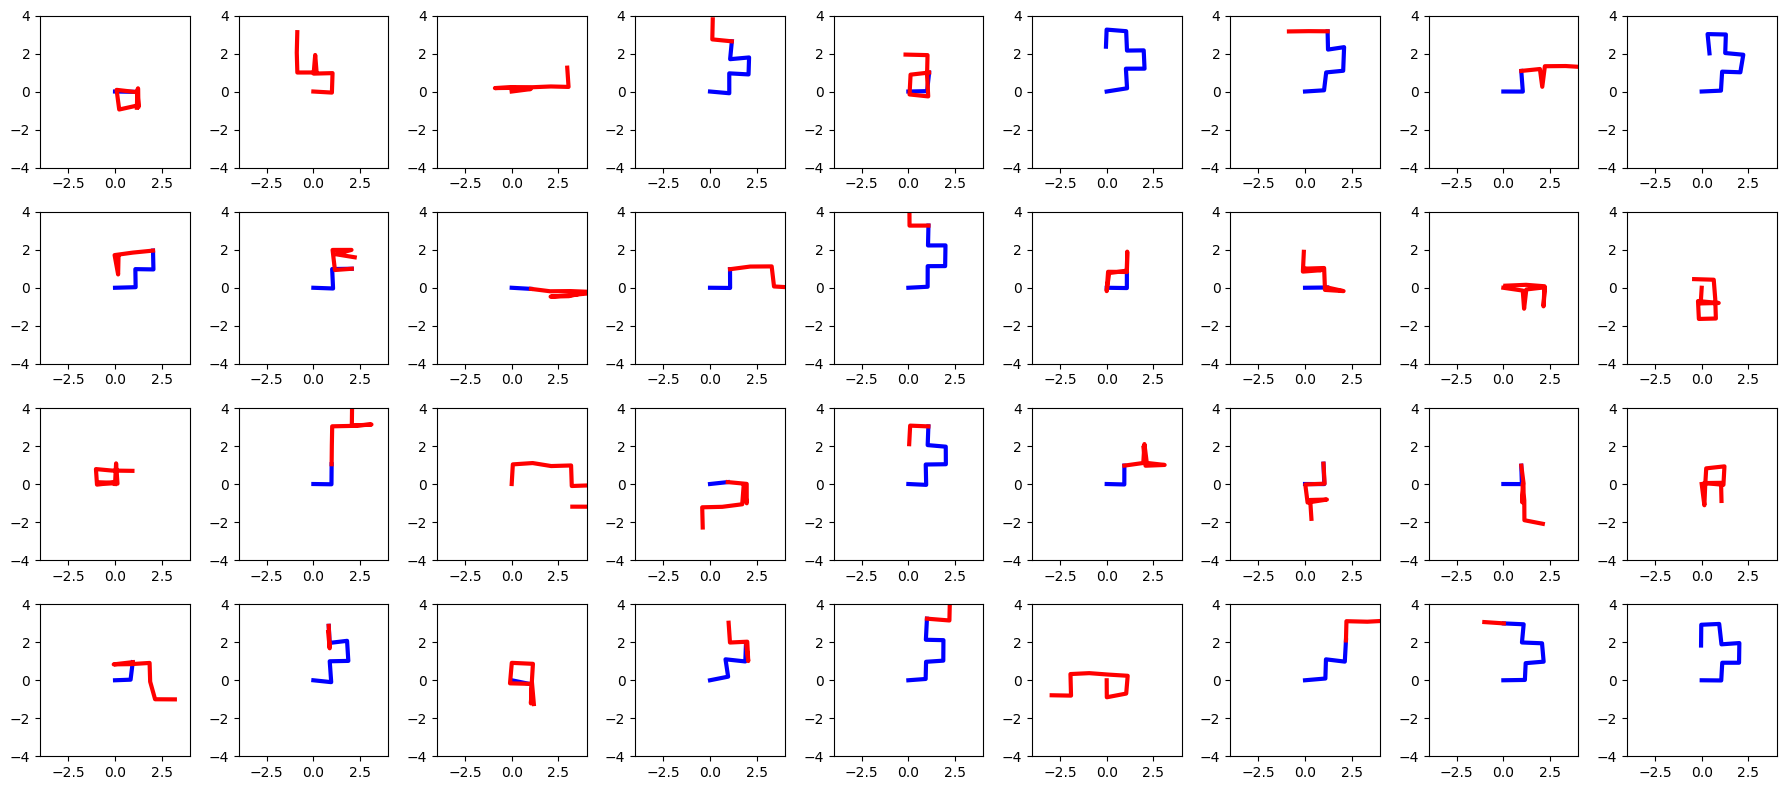

In [115]:
u = ["R","U","R","U","L","U","L","D"]
traces = []
log_weights = []
for replicate=1:36
    trace = Trace()
    controlled_robot_program(trace, u)
    push!(traces, trace)
    push!(log_weights, trace.log_weight)
end

#plotting
plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    obs_xs =  map((i) -> trace["x$i"], 1:length(u))
    obs_ys =  map((i) -> trace["y$i"], 1:length(u))
    render_observed_path_trace(trace, obs_xs, obs_ys, ax, xlim, ylim)
end
plt[:tight_layout]()

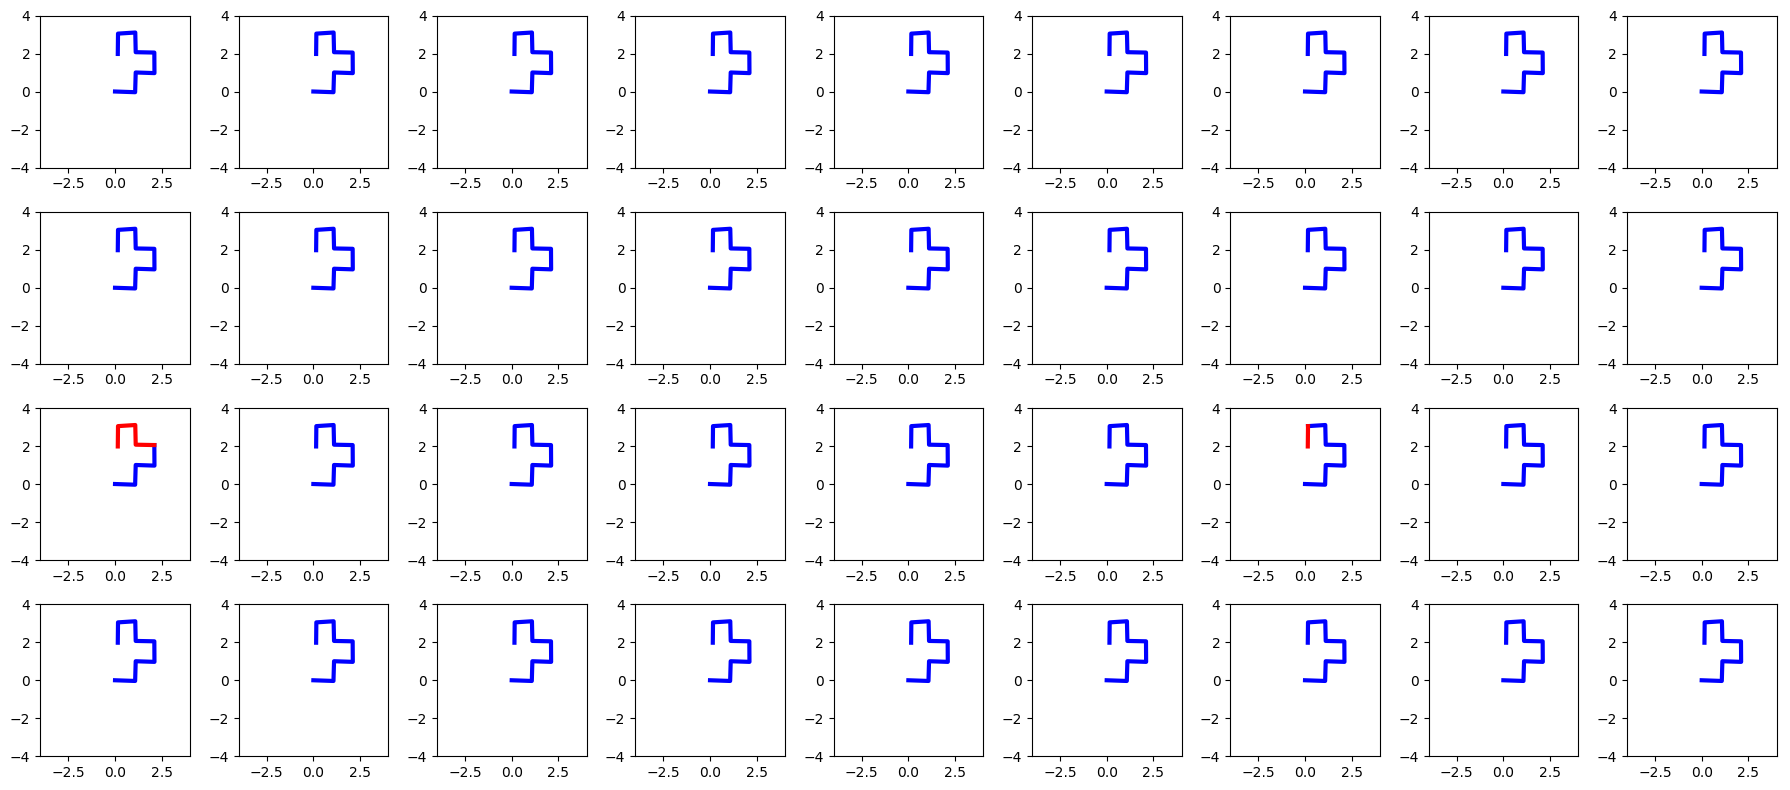

In [118]:
u = ["R","U","R","U","L","U","L","D"]
xs = [1.07527,1.10607,2.10857,2.10132,1.10599,1.08273,0.159893,0.147748]
ys = [-0.0365053,1.00158,0.96829,2.04956,2.06928,3.1048,3.04657,1.97649]

traces = []
num_samples = 1000
for replicate=1:36
    trace = Trace()
    push!(traces, robot_control_likelihood_weighting(num_samples, xs, ys))
end

plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    render_observed_path_trace(trace, xs, ys, ax, xlim, ylim)
end

plt[:tight_layout]()


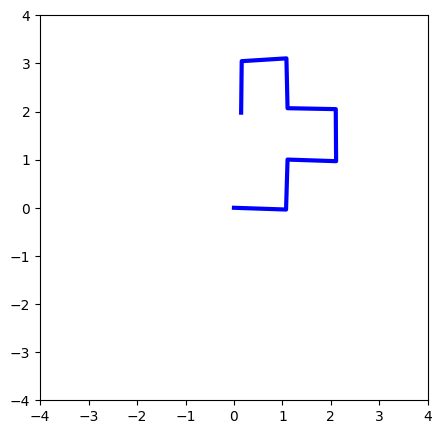

(-4,4)

In [106]:
u = ["R","U","R","U","L","U","L","D"]
trace = Trace()
dxs, dys = controlled_robot_program(trace, u)

plt[:figure](figsize=(5, 5))

zero_start_xs = [0.]
zero_start_ys = [0.]

zero_start_xs = vcat(zero_start_xs, map((i) -> trace["x$i"], 1:length(u)))
zero_start_ys = vcat(zero_start_ys, map((i) -> trace["y$i"], 1:length(u)))

bs = map((i) -> trace["b$i"], 1:length(u))
broken_index = findfirst(bs, true)
if broken_index != 0
    plt[:plot](zero_start_xs[1:broken_index], zero_start_ys[1:broken_index], color="blue", lw=3)
    plt[:plot](zero_start_xs[broken_index:end], zero_start_ys[broken_index:end], color="red", lw=3)
else
    plt[:plot](zero_start_xs, zero_start_ys, color="blue", lw=3)
end

plt[:xlim](-4,4)
plt[:ylim](-4,4)